## Business challenge.
Financial institutions struggle with evaluating loan applicants efficiently, leading to approval delays, high default rates and potential biases. Traditional models rely on rigid criteria, overlooking valuable insights from alternative data.

Loan Approval Predictor aims to build a predictive model that leverages historical loan data, borrower profiles  and classification techniques to refine loan approval decisions. By enhancing risk assessment and promoting fair, accessible credit opportunities, it seeks to improve financial inclusion and operational efficiency.


In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  





### 1.Data Review

In [2]:
#Load the dataset in Python using pandas and inspect the first few rows

df=pd.read_csv("loan_data.csv")
df.head(10)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


This dataset contains loan application records, including applicant demographics, financial details, credit history and loan approval status. It aims to identify patterns in borrower profiles and factors influencing loan approvals.

In [3]:
# Checking the shape of the dataset (rows, columns)

df.shape

(45000, 14)

In [4]:
# Checking dataset structure and column details

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

 The above displays the number of non-null values, data types and memory usage, 
helping us identify missing data and potential type conversions.


In [5]:
# List categorical columns

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical features:", categorical_columns)



Categorical features: Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')


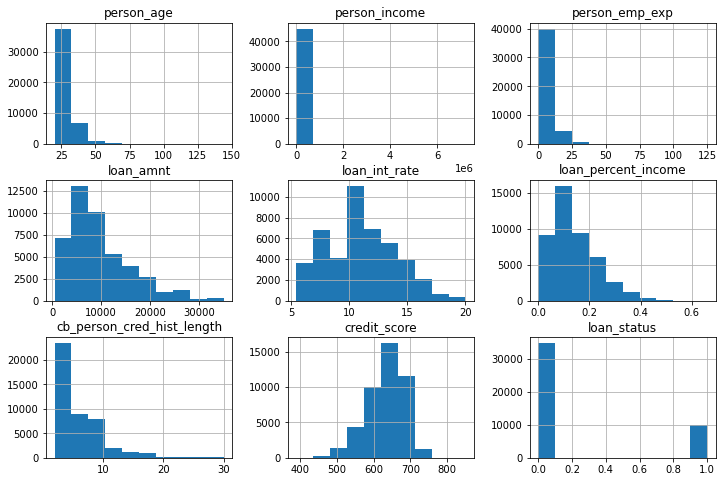

In [6]:
# Plot histograms for numerical features

df.hist(figsize=(12, 8))
plt.show()



The image presents nine bar charts visualizing key attributes of loan applicants, including age distribution,annual income, work experience, loan amounts, interest rates, debt-to-income ratio,credit history length, credit scores and loan approval rates. The visualizations highlight trends, such as most applicants being between 20-50 years old, earning under $2 million annually, and maintaining credit scores in the 600-800 range. Additionally, the majority of loans are under $10,000, with approval rates favoring financially stable borrowers. These insights help assess borrowing patterns and potential risk factors in loan approvals.


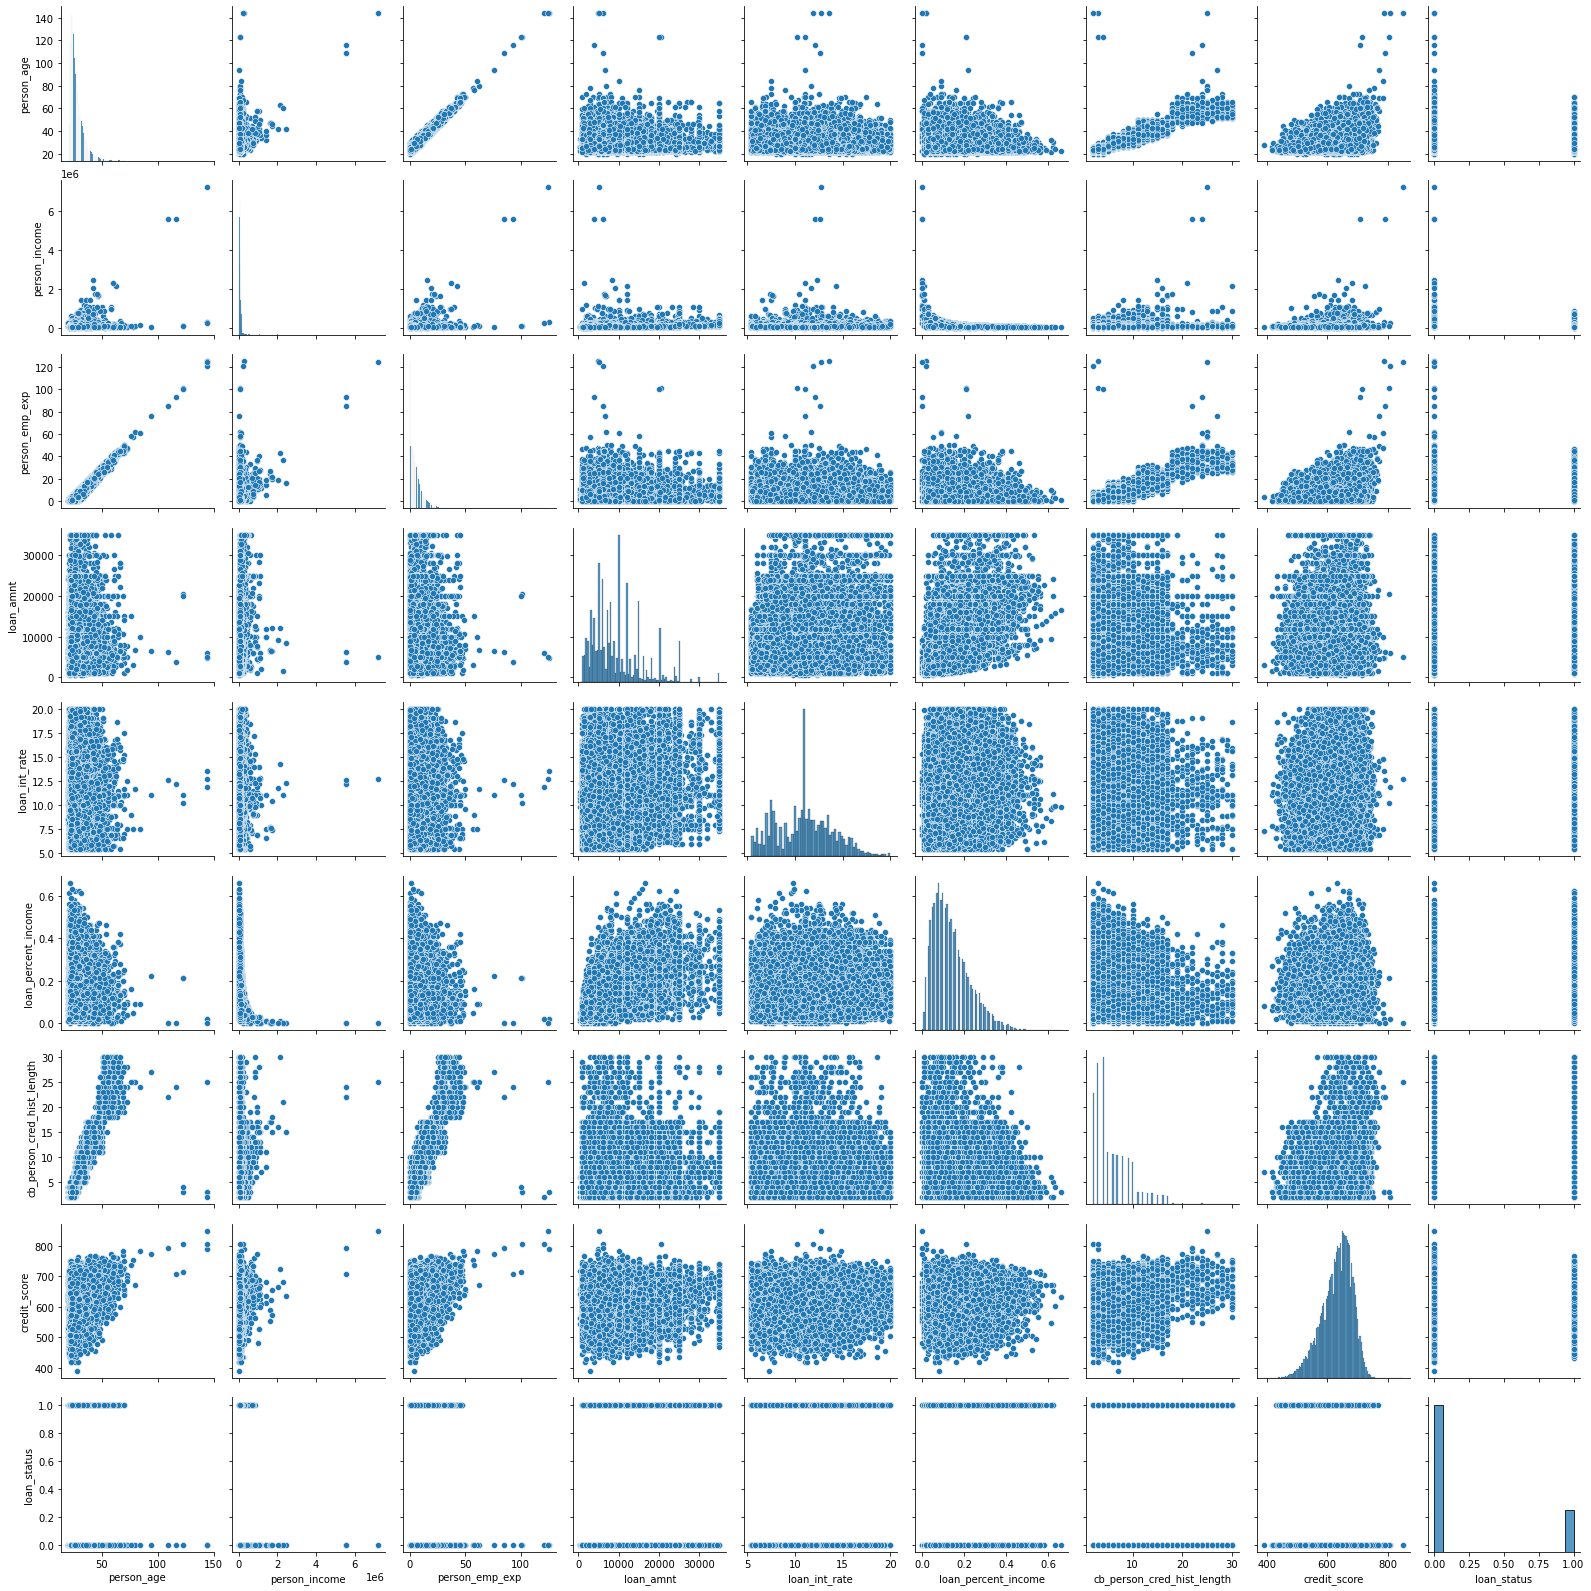

In [ ]:
#Plot pairplot for multiple numerical variables to identify relationships

sns.pairplot(df)
plt.show()



